In [1]:
import sys
sys.path.append('C:/Users/320060820/experiments/')
import fxp_quantize
import model_data

import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tnrange, tqdm_notebook

# to restart layer numbering
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [2]:
def fix_weights_quantization(model, parameters):
    
    for k in parameters.keys():
        model.model = fxp_quantize.quantize_weights(model.model, parameters[k][0], parameters[k][1],
                                                   layer_name=[k], sqrt=True)
    return model
    

def brute_force_analysis_weights(model, layer_names, bw_range, f_range, fix_quant=False, parameters=None, 
                         eval_metric='acc_drop'):
    
    if fix_quant and parameters is None:
        raise ValueError('Parameters is empty')
    
    if not isinstance(layer_names, list):
        layer_names = [layer_names]
    
    for i in layer_names:

        scores_matrix = []

        for j in tnrange(len(bw_range), desc=f'BW Layer {i}', leave=False):
            scores_row = []
            
            for k in tqdm_notebook(range(len(f_range)), desc='F', leave=False):

                model.load_model_from_path()

                if fix_quant:
                    #fix quantization for certain layers
                    model = fix_weights_quantization(model, parameters)

                model.model = fxp_quantize.quantize_weights(model.model, bw_range[j], f_range[k],
                                                            layer_name=[i], sqrt=True)
                scores_row.append(model.evaluate_accuracy()[1])

            scores_matrix.append(scores_row)

        scores = np.array(scores_matrix)

        if layer_names.index(i) == 0:
            model_scores = scores
        else:
            model_scores = np.dstack((model_scores, scores))
        
        print(f'Layer {i} done.')
        
    model.load_model_from_path()
    s = model.evaluate_accuracy()[1]
    
    if eval_metric == 'acc_drop':
        model_scores = (s - model_scores) / s
        
    elif eval_metric == 'acc_ratio':
        model_scores = model_scores / s
        
    elif eval_metric == 'quant_acc':
        pass
        
    return model_scores

In [3]:
def plot_results(scores, layer_names, rows, columns, figsize, shrink, bw_range, f_range, invert=False, vmax=None):
    
    if len(scores.shape) < 3:
        scores = np.expand_dims(scores, axis=3)
    fig, ax = plt.subplots(rows, columns, figsize=figsize)
    cbar_ax = fig.add_axes([.91, 0.1, .02, 0.8])
    if rows == 1 and columns == 1:
        ax = [ax]
    else:
        ax = ax.flatten()
    vmin = scores.min()
    if vmax is None:
        vmax = scores.max()
    else:
        vmax=vmax
    t = np.arange(0.0, vmax, 0.1).tolist()
    for i in range(scores.shape[2]):
        sns.heatmap(scores[:, :, i], annot=True, fmt='.3f', ax=ax[i], xticklabels=f_range, 
                    yticklabels=bw_range, vmin = vmin, vmax=vmax, cbar_ax=cbar_ax)#, cbar_kws={"ticks":t})
#         sns.heatmap(scores[:, :, i], annot=True, fmt='.2f', vmin=vmin, vmax=vmax, cbar_ax=cbar_ax)
        ax[i].set_xlabel('Fractional offset')
        ax[i].set_ylabel('Bitwidth')
        ax[i].set_title(f'Layer {layer_names[i]}')
        if invert:
            ax[i].invert_yaxis()
    if rows*columns - scores.shape[2] != 0:
        for i in range(1, rows*columns - scores.shape[2] + 1):
            fig.delaxes(ax[-i])

In [3]:
# config
save_path = 'C:/Users/320060820/experiments/test_models/'
# output_path = 'C:/Users/320060820/experiments/outputs/Brute_Force_Analysis/Weights/Keras_CIFAR10/'
bw_range = np.arange(1, 11, 1)
f_range = np.arange(1, 11, 1)
layer_names = [f'conv2d_{i}' for i in range(1, 5)] + ['dense_1']
vmax=0.1

In [4]:
name = 'cifar_keras'
model_path = 'cifar_keras/cifar_keras_new.h5'

from test_models.cifar_keras import data
_, test_data = data.get_data()

keras_cifar = model_data.Model(name, test_data, path=save_path + model_path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
scores = brute_force_analysis_weights(keras_cifar, layer_names, bw_range, f_range)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


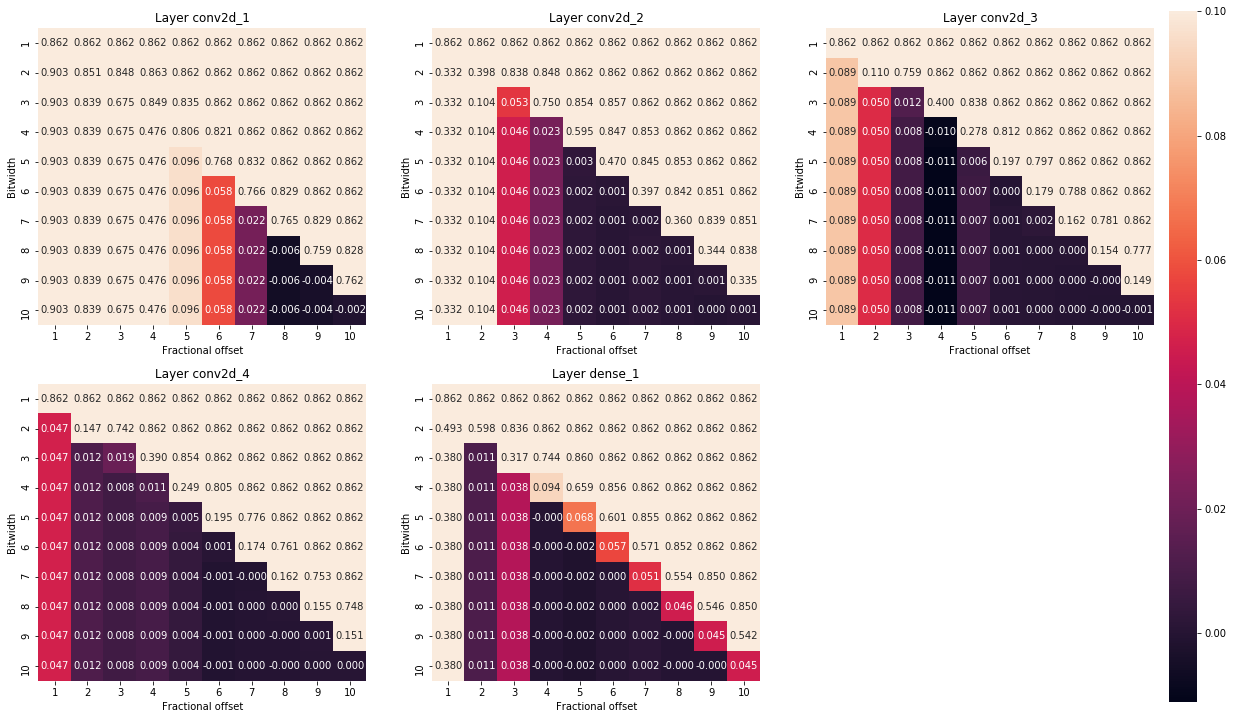

In [23]:
plot_results(scores, layer_names, 2, 3, (20, 12), 0.8, bw_range, f_range, vmax=vmax)

In [15]:
keras_cifar.load_model_from_path()
weights = keras_cifar.get_model_weights_by_layer()
keras_cifar.model = fxp_quantize.quantize_weights(keras_cifar.model, 6, 5, layer_name=layer_names[1:2], sqrt=True)
print(keras_cifar.evaluate_accuracy()[1])
new_weights = keras_cifar.get_model_weights_by_layer()

0.7226


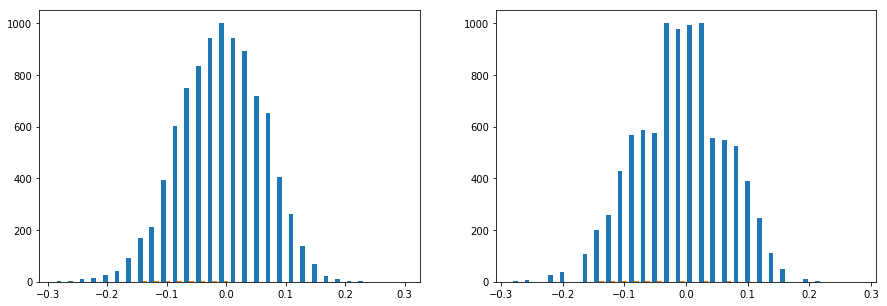

In [21]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(weights[1], bins=30);
plt.subplot(1, 2, 2)
plt.hist(new_weights[1], bins=30);

In [29]:
params = {
    'conv2d_1': [8, 8],
}
scores_2 = brute_force_analysis_weights(keras_cifar, layer_names[1:], bw_range, f_range, fix_quant=True, parameters=params)

Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


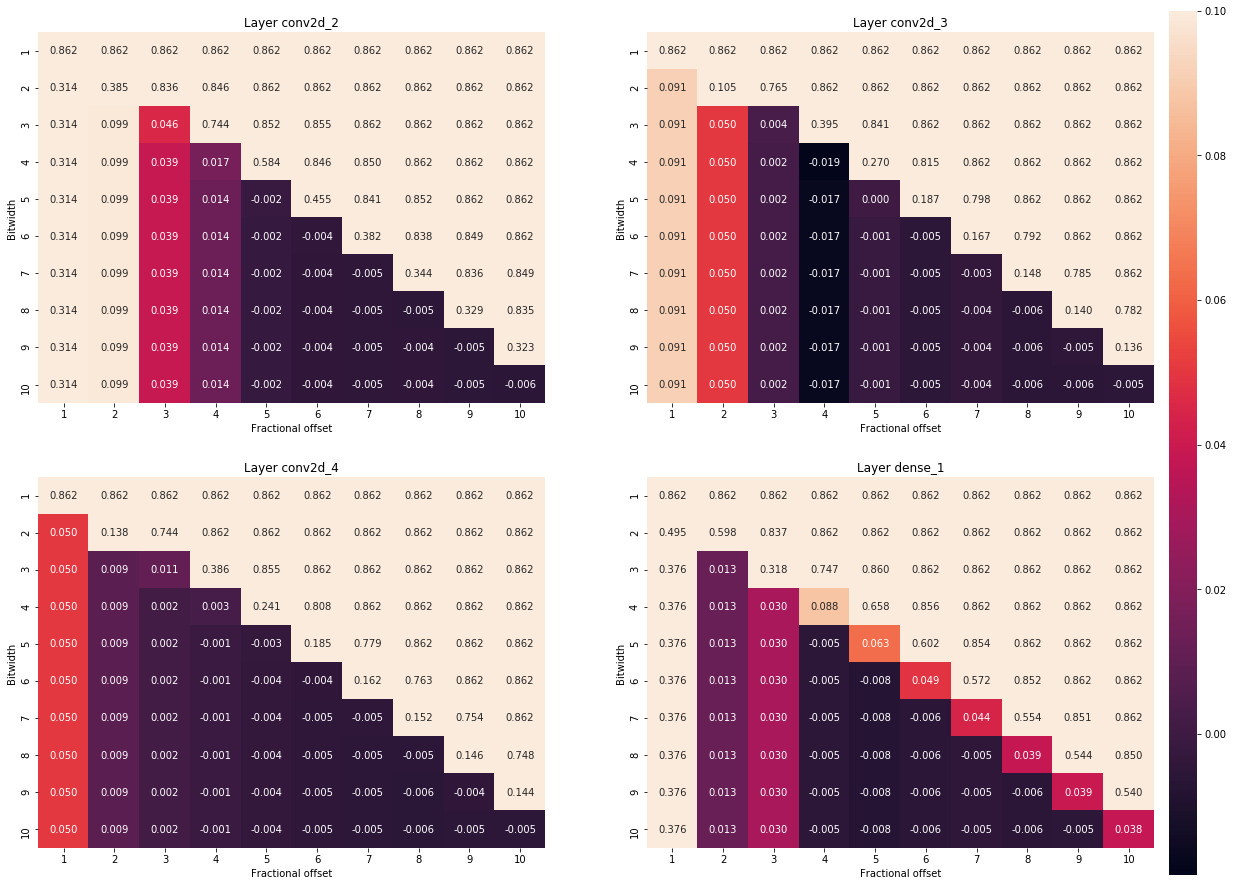

In [30]:
plot_results(scores_2, layer_names[1:], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

In [31]:
params = {
    'conv2d_1': [8, 8],
    'conv2d_2': [5, 5]
}
scores_3 = brute_force_analysis_weights(keras_cifar, layer_names[2:], bw_range, f_range, fix_quant=True, parameters=params)

Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


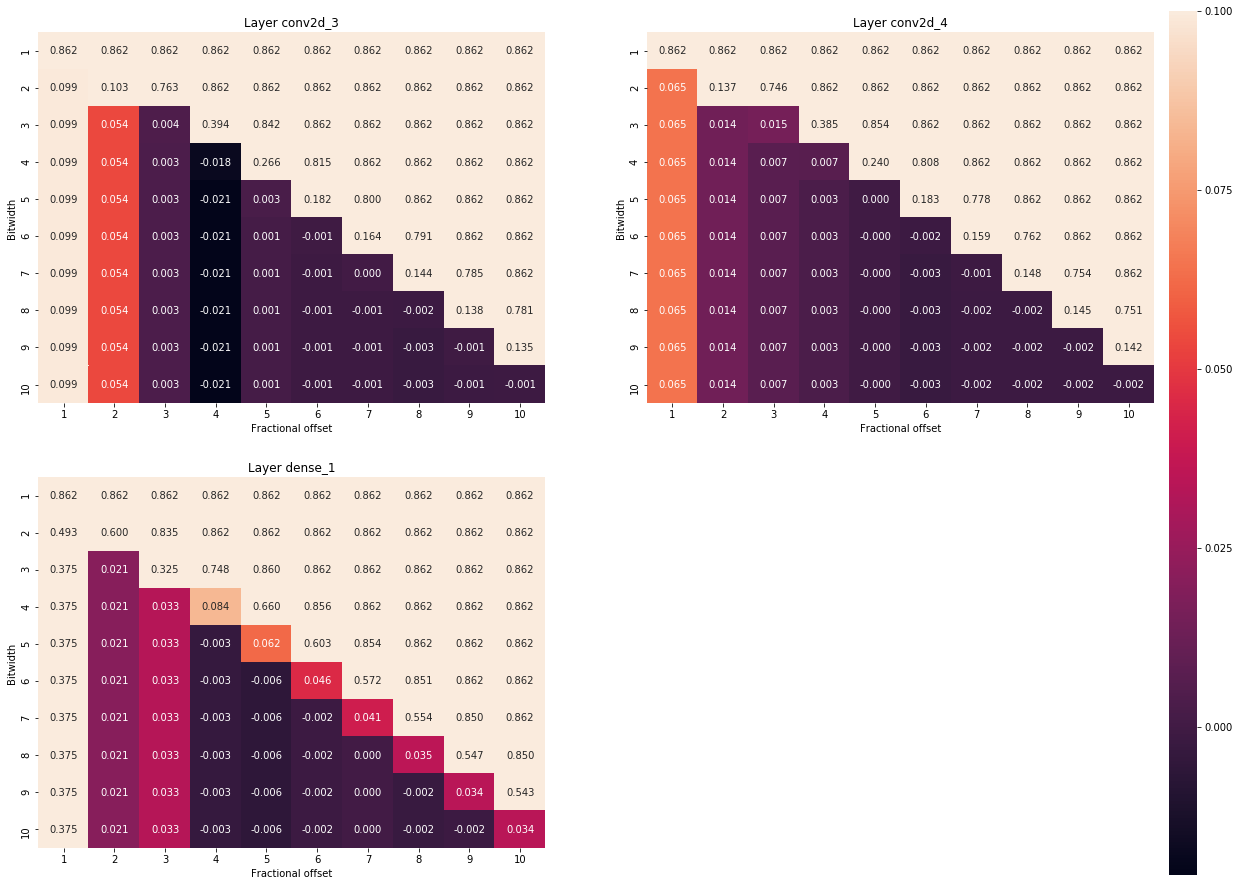

In [32]:
plot_results(scores_3, layer_names[2:], 2, 2, (20, 15), 0.8, bw_range, f_range, vmax=vmax)

# MNIST

In [33]:
name = 'mnist_keras'
model_path = 'mnist_custom/mnist_keras.h5'

from test_models.mnist_custom import data
_, test_data = data.get_data()

keras_mnist = model_data.Model(name, test_data, path=save_path+model_path)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [34]:
scores = brute_force_analysis_weights(keras_mnist, layer_names, bw_range, f_range)

Layer conv2d_1 done.


Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


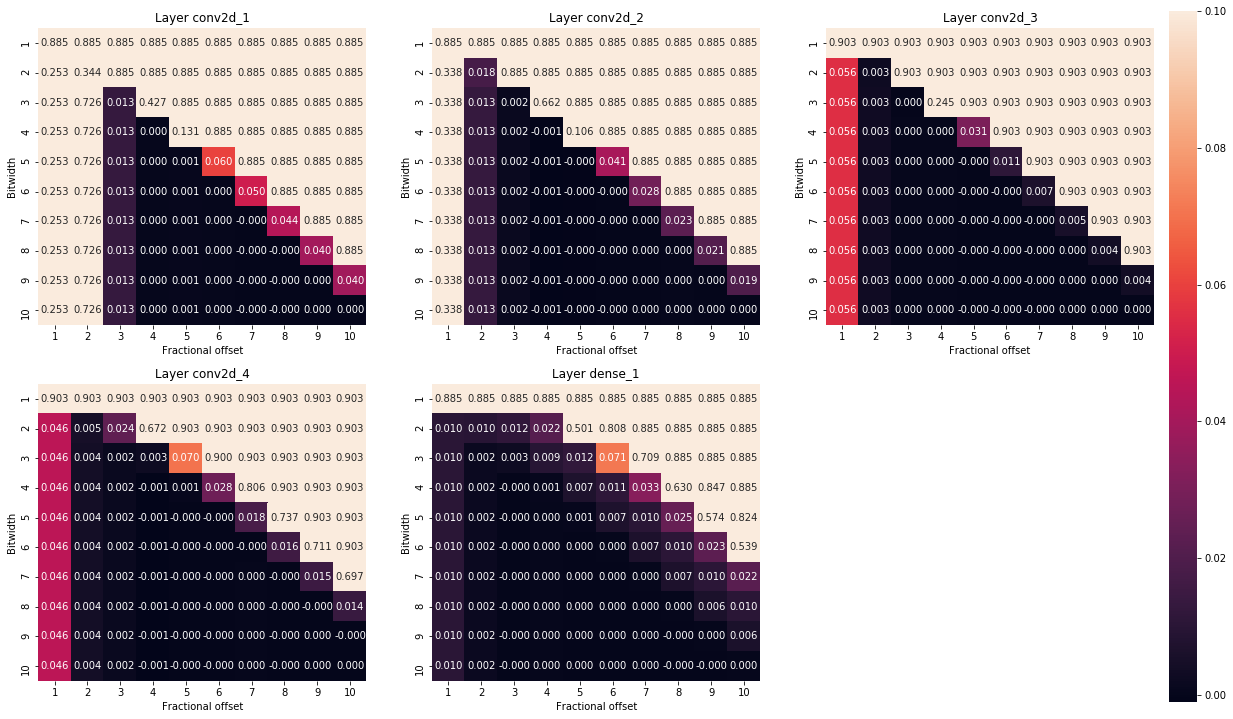

In [38]:
plot_results(scores, layer_names, 2, 3, (20, 12), 0.8, bw_range, f_range, vmax=vmax)

In [37]:
params = {
    'conv2d_1': [4, 4]
}
scores_2 = brute_force_analysis_weights(keras_mnist, layer_names[1:], bw_range, f_range, fix_quant=True, parameters=params)

Layer conv2d_2 done.


Layer conv2d_3 done.


Layer conv2d_4 done.


Layer dense_1 done.


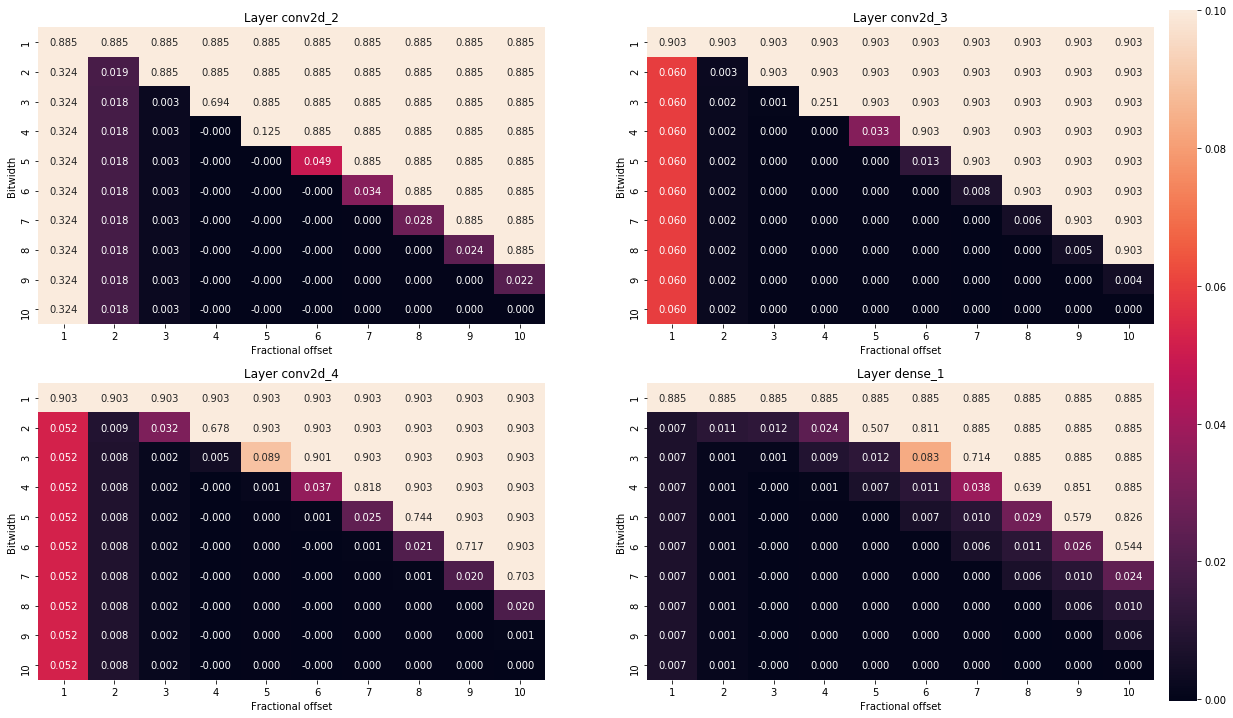

In [39]:
plot_results(scores_2, layer_names[1:], 2, 2, (20, 12), 0.8, bw_range, f_range, vmax=vmax)

In [5]:
keras_cifar.load_model_from_path()
w = keras_cifar.get_model_weights_by_layer(dense = True)

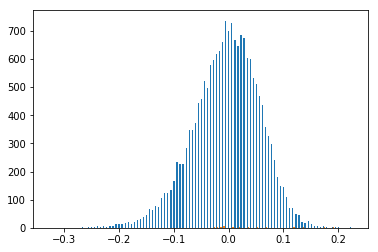

In [6]:
plt.hist(w[2], bins=100);

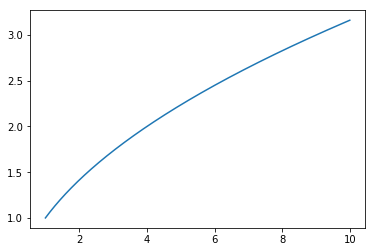

In [16]:
x = np.linspace(1, 10, 1000)
y = np.sqrt(x)
plt.plot(x, y)

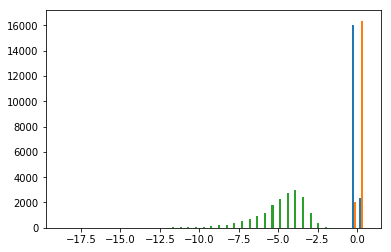

In [19]:
w_abs = np.abs(w[2][0])
w_sqrt = np.sqrt(np.abs(w[2][0]))
w_log2 = np.log2(np.abs(w[2][0]))
plt.hist([w_abs.flatten(), w_sqrt.flatten(), w_log2.flatten()], bins=40);

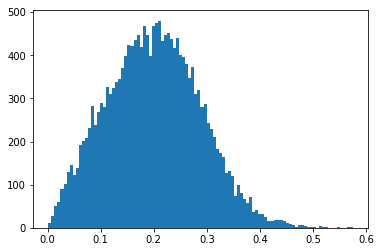

In [11]:
w_sqrt = np.sqrt(np.abs(w[2][0]))
plt.hist(w_sqrt.flat, bins=100);